In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S3"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1652 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

### Aggregate probes through max-pooling

In [4]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

AnnData object with n_obs × n_vars = 1652 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [5]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.936
Zero inflation of aggregated data: 0.831


### Filter cells

--> filter baased on mean absolute standard deviation

In [6]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1544
True      108
Name: count, dtype: int64
Total number of cells: 1652
Number of cells after filtering: 1544


AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

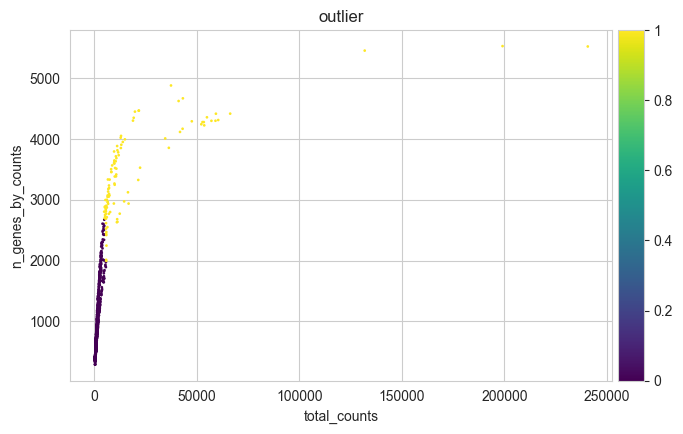

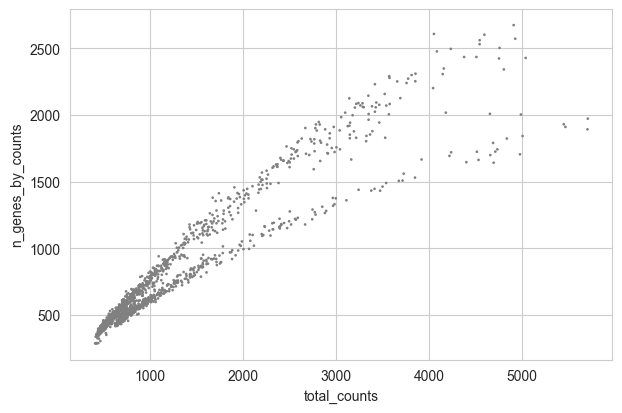

In [7]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis")
plt.show()
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [8]:
data_gene.layers["counts"] = data_gene.X.copy()

In [120]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

## Estimate negative binomial parameters for each gene

In [10]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts")

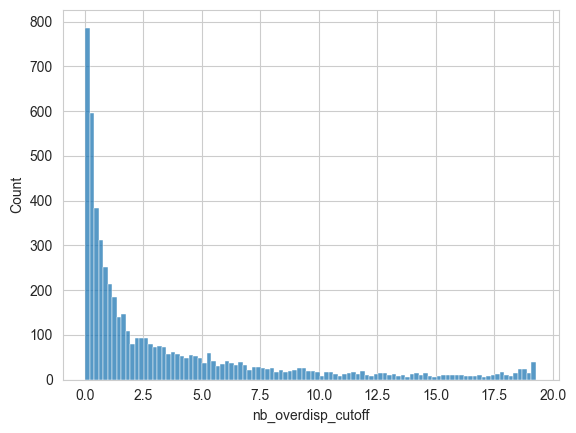

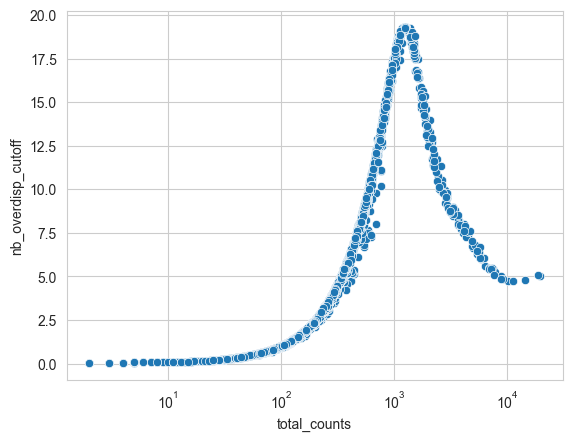

In [11]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="total_counts")
g.set(xscale="log")
plt.show()

In [127]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [128]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(data_gene, svd_solver='arpack')

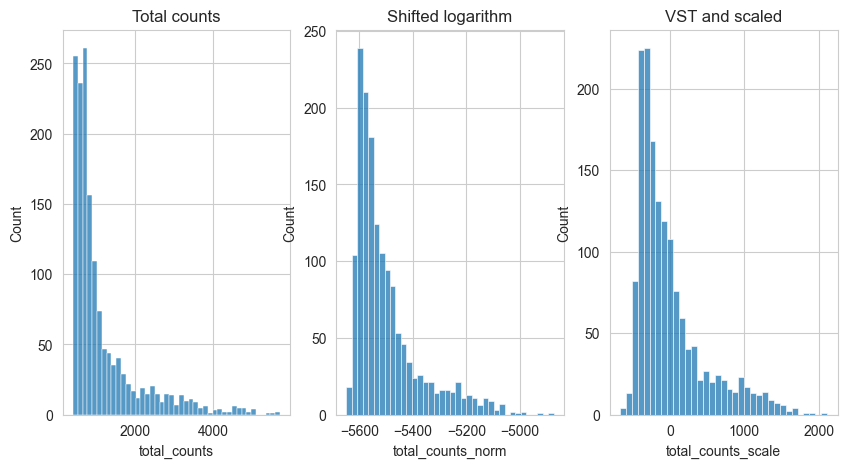

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.show()

## Count-splitting into train and test data

In [130]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=None)
print(data_train)

AnnData object with n_obs × n_vars = 1544 × 5541
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'
    layers: 'counts'


In [131]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

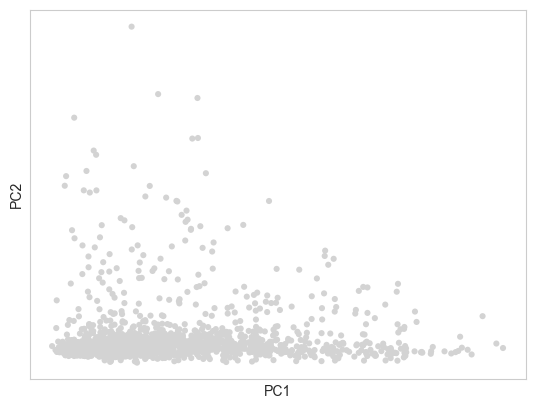

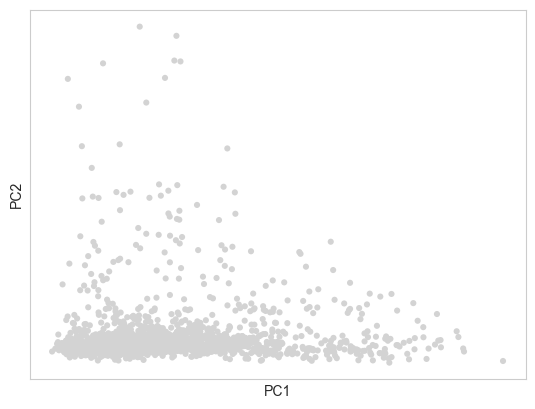

In [126]:
sc.pl.pca(data_train)
plt.show()

sc.pl.pca(data_test)
plt.show()

### Principal component selection

In [18]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


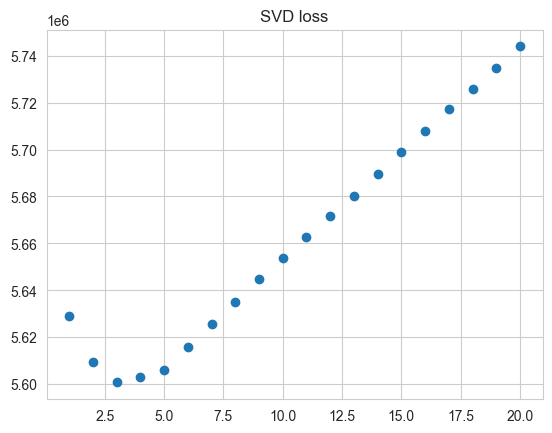

3 PCs seems to be the optimum


In [19]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.show()

print(f"{k_opt} PCs seems to be the optimum")

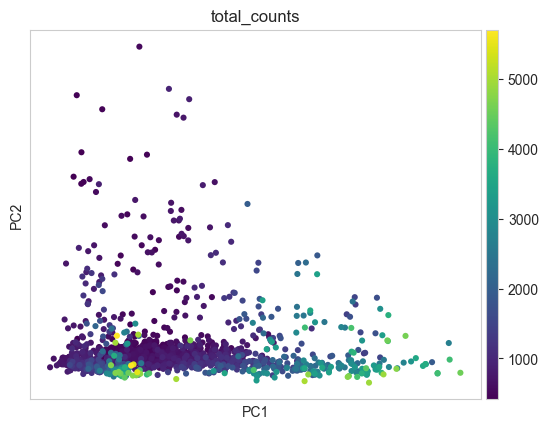

In [20]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis")
plt.show()

In [21]:
print(data_gene)

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'


## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [98]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 100
Optimal min_dist: 0.5


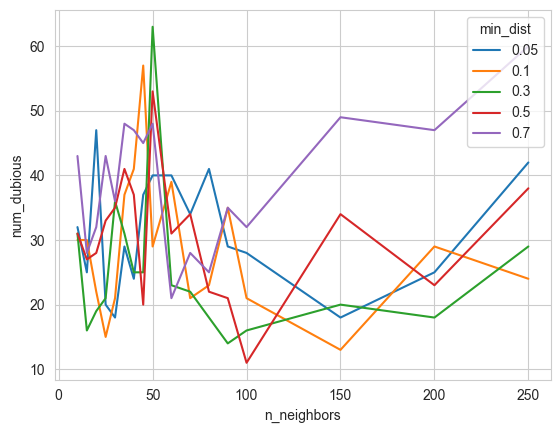

In [99]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.show()

In [100]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


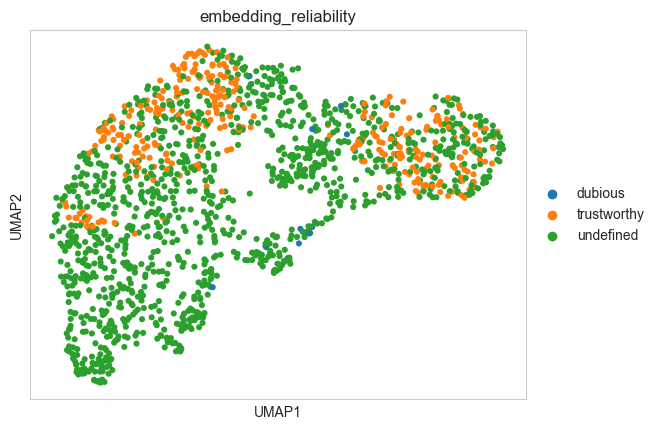

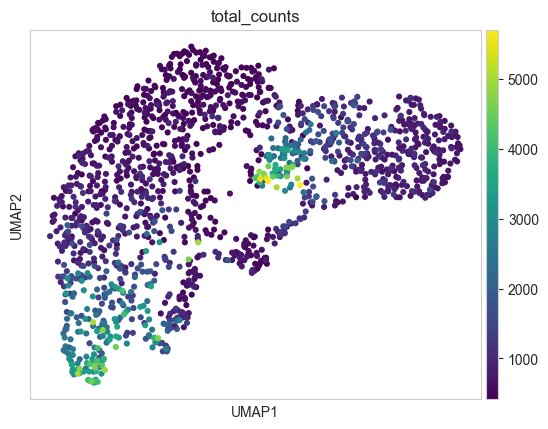

In [101]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [102]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [103]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

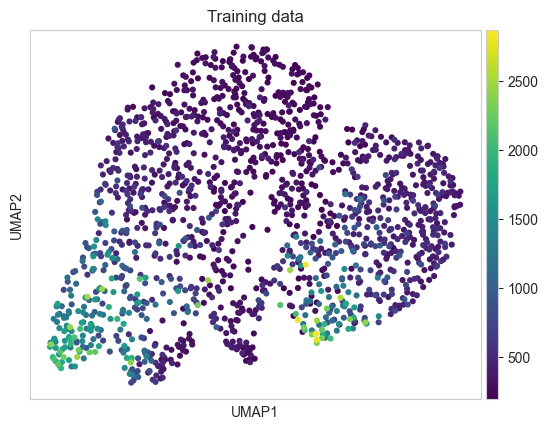

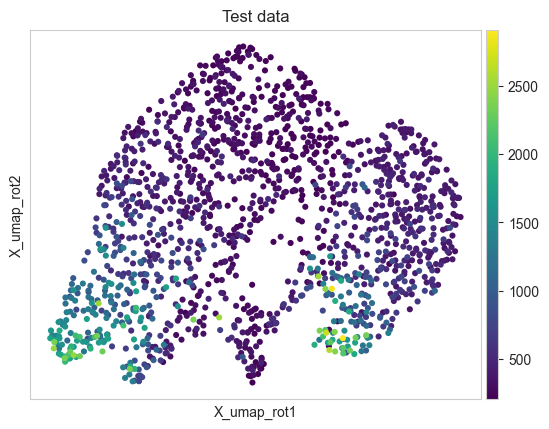

In [104]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [105]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

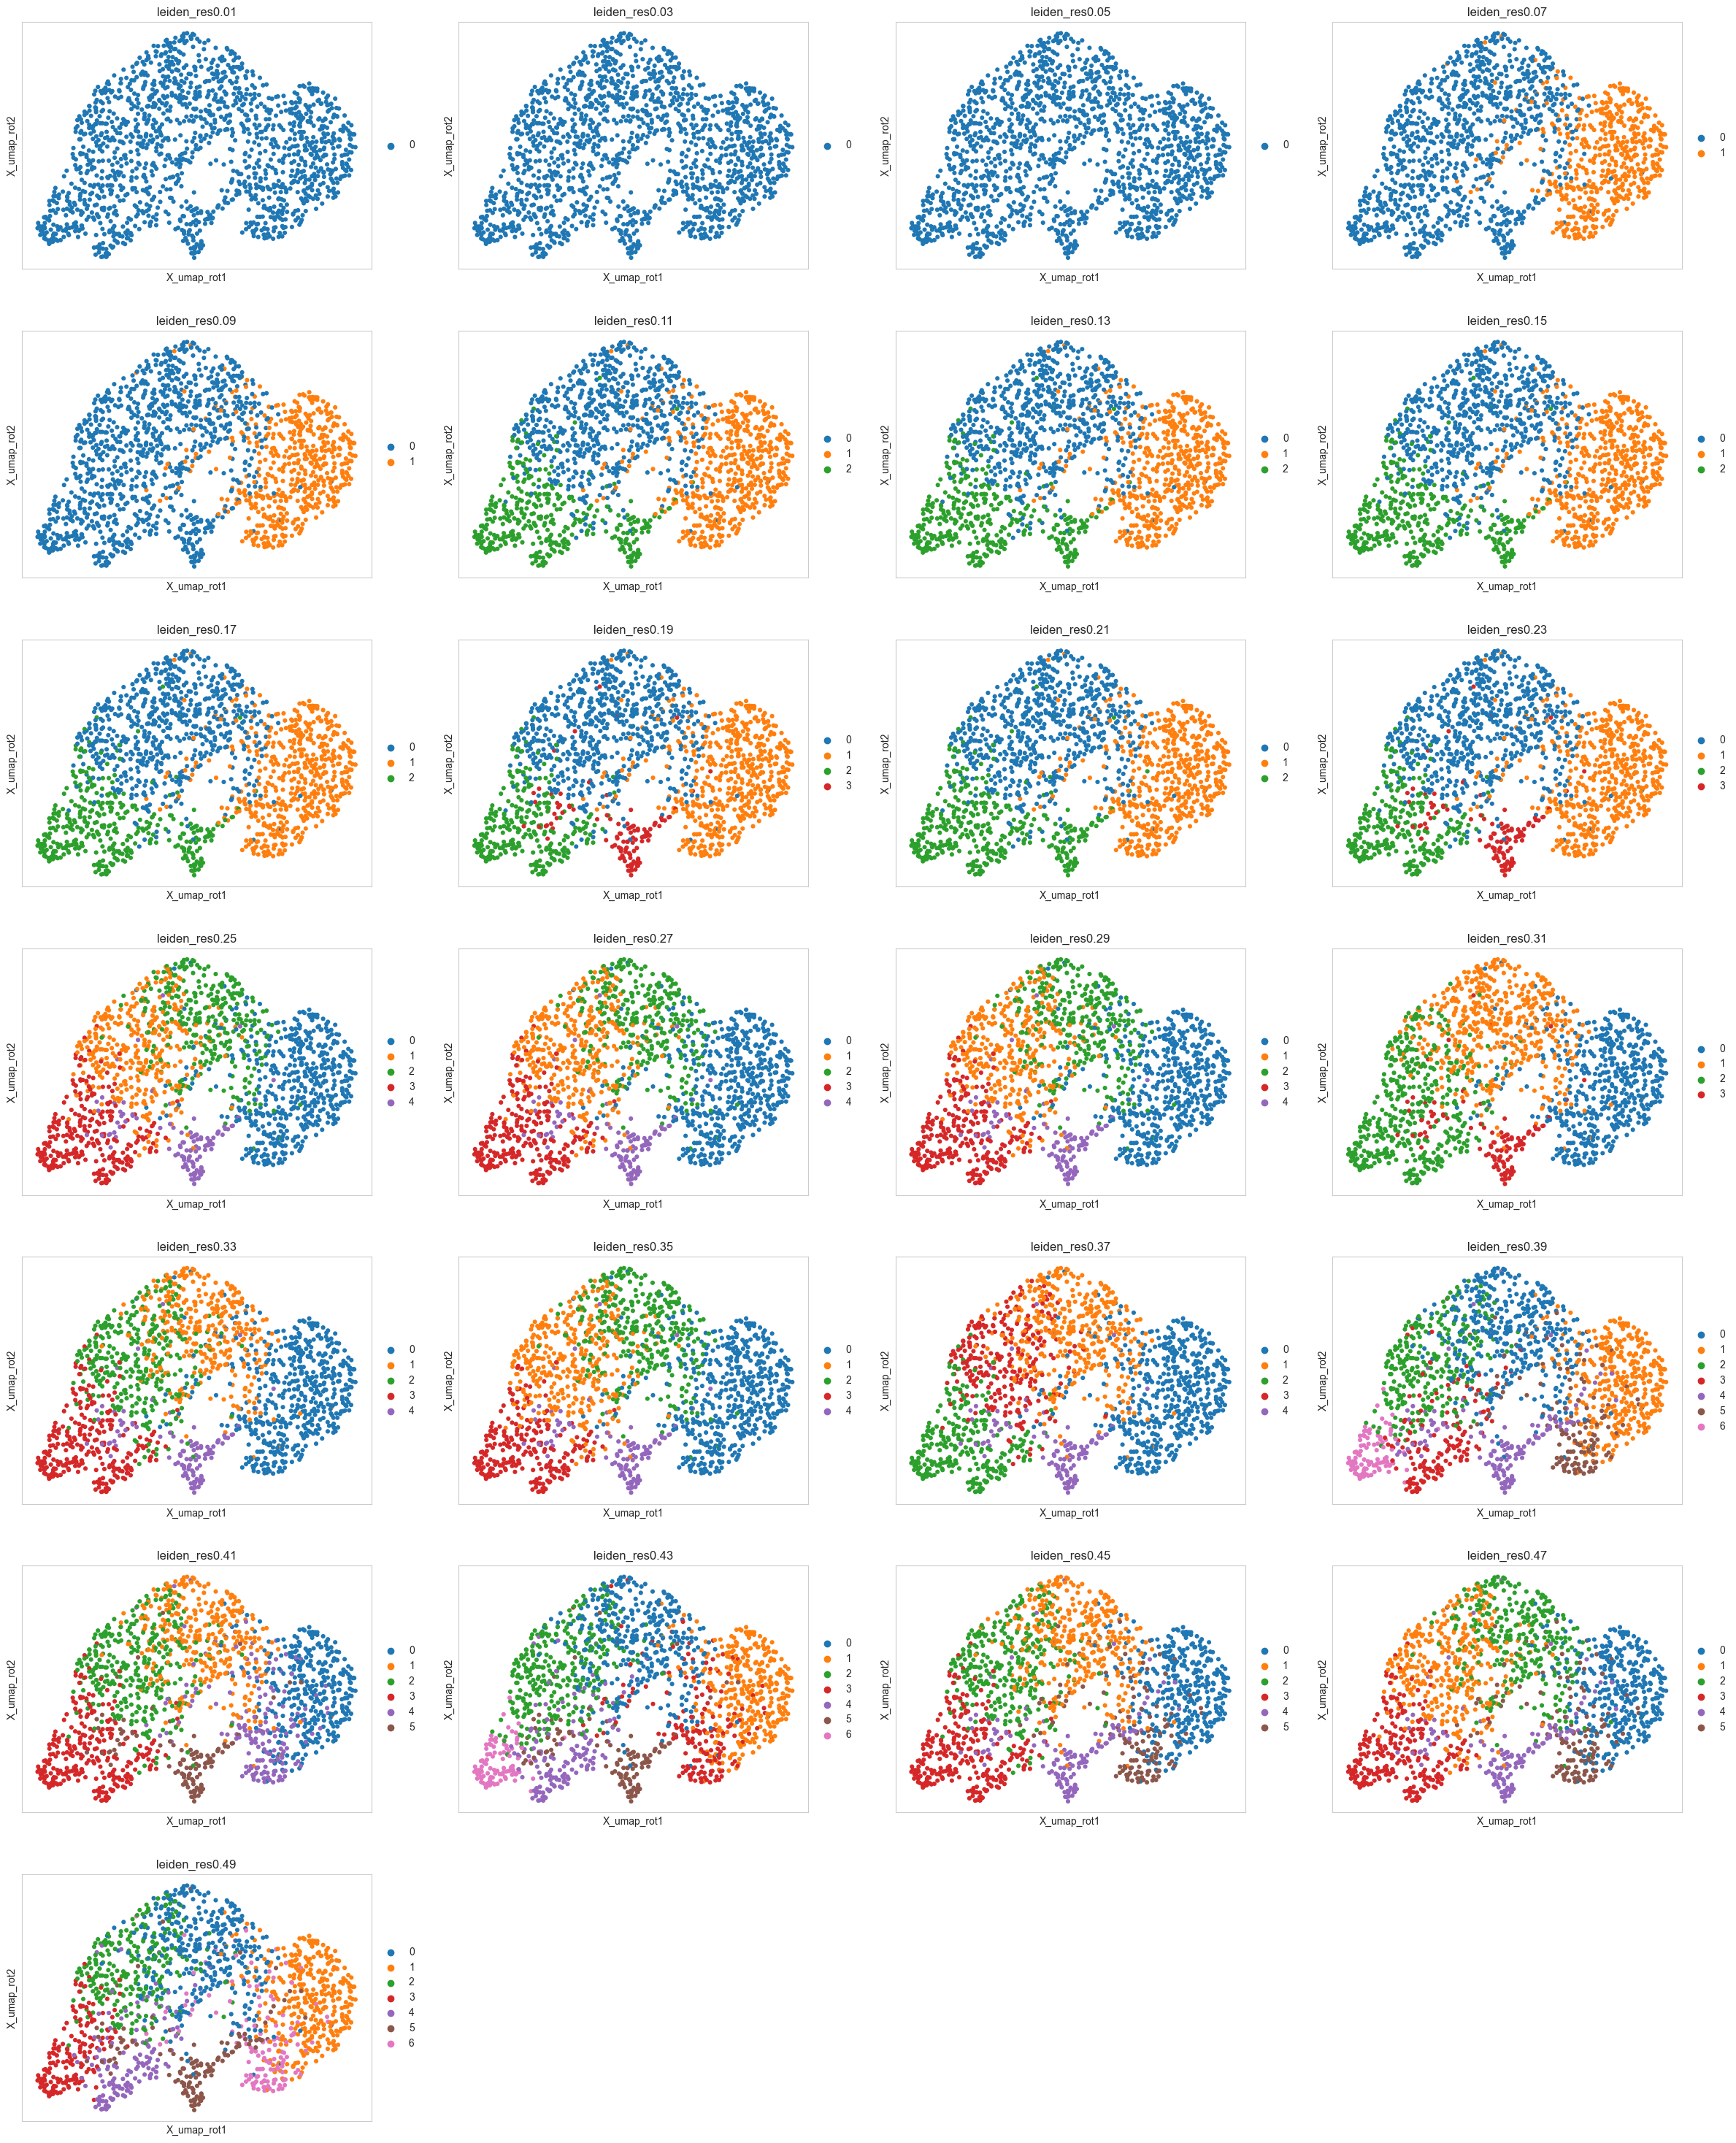

In [106]:
# sc.pl.umap(data_train, color=[f"leiden_res{resolution}" for resolution in resolutions])
# plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

Modularities

In [107]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 1 - Train: 0.45 - Test: 0.45 - Random: 0.45
resolution: 0.07 - clusters: 2 - Train: 0.434 - Test: 0.411 - Random: 0.239
resolution: 0.09 - clusters: 2 - Train: 0.424 - Test: 0.399 - Random: 0.227
resolution: 0.11 - clusters: 3 - Train: 0.406 - Test: 0.37 - Random: 0.137
resolution: 0.13 - clusters: 3 - Train: 0.399 - Test: 0.363 - Random: 0.129
resolution: 0.15 - clusters: 3 - Train: 0.392 - Test: 0.356 - Random: 0.122
resolution: 0.17 - clusters: 3 - Train: 0.385 - Test: 0.349 - Random: 0.115
resolution: 0.19 - clusters: 4 - Train: 0.378 - Test: 0.341 - Random: 0.099
resolution: 0.21 - clusters: 3 - Train: 0.371 - Test: 0.335 - Random: 0.1
resolution: 0.23 - clusters: 4 - Train: 0.365 - Test: 0.328 - Random: 0.087
resolution: 0.25 - clusters: 5 - Train: 0.36 - Test: 0.296 - Random: 0.057
resolution: 0.27 - cluste

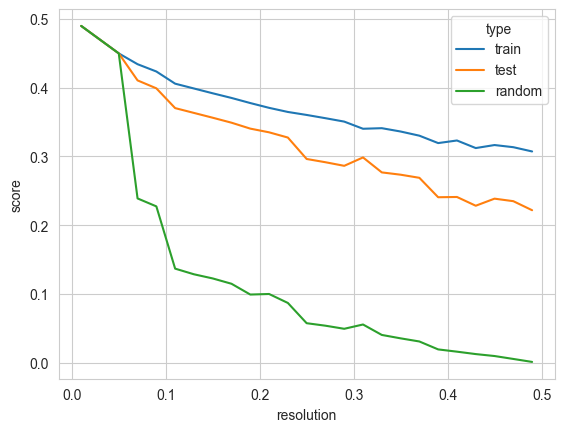

In [108]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

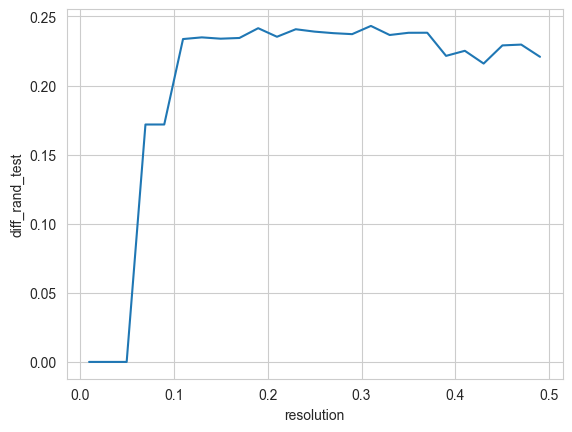

In [109]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [110]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

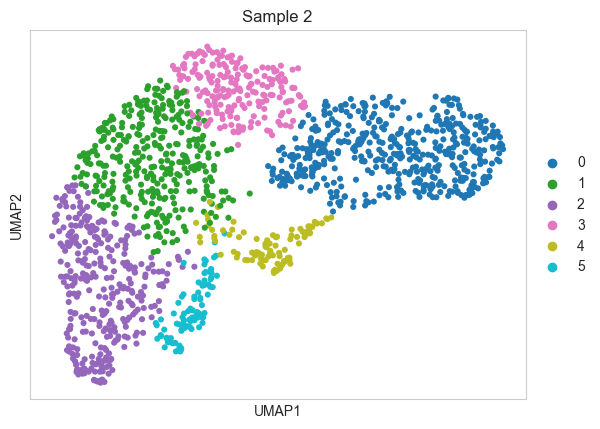

In [111]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

In [112]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

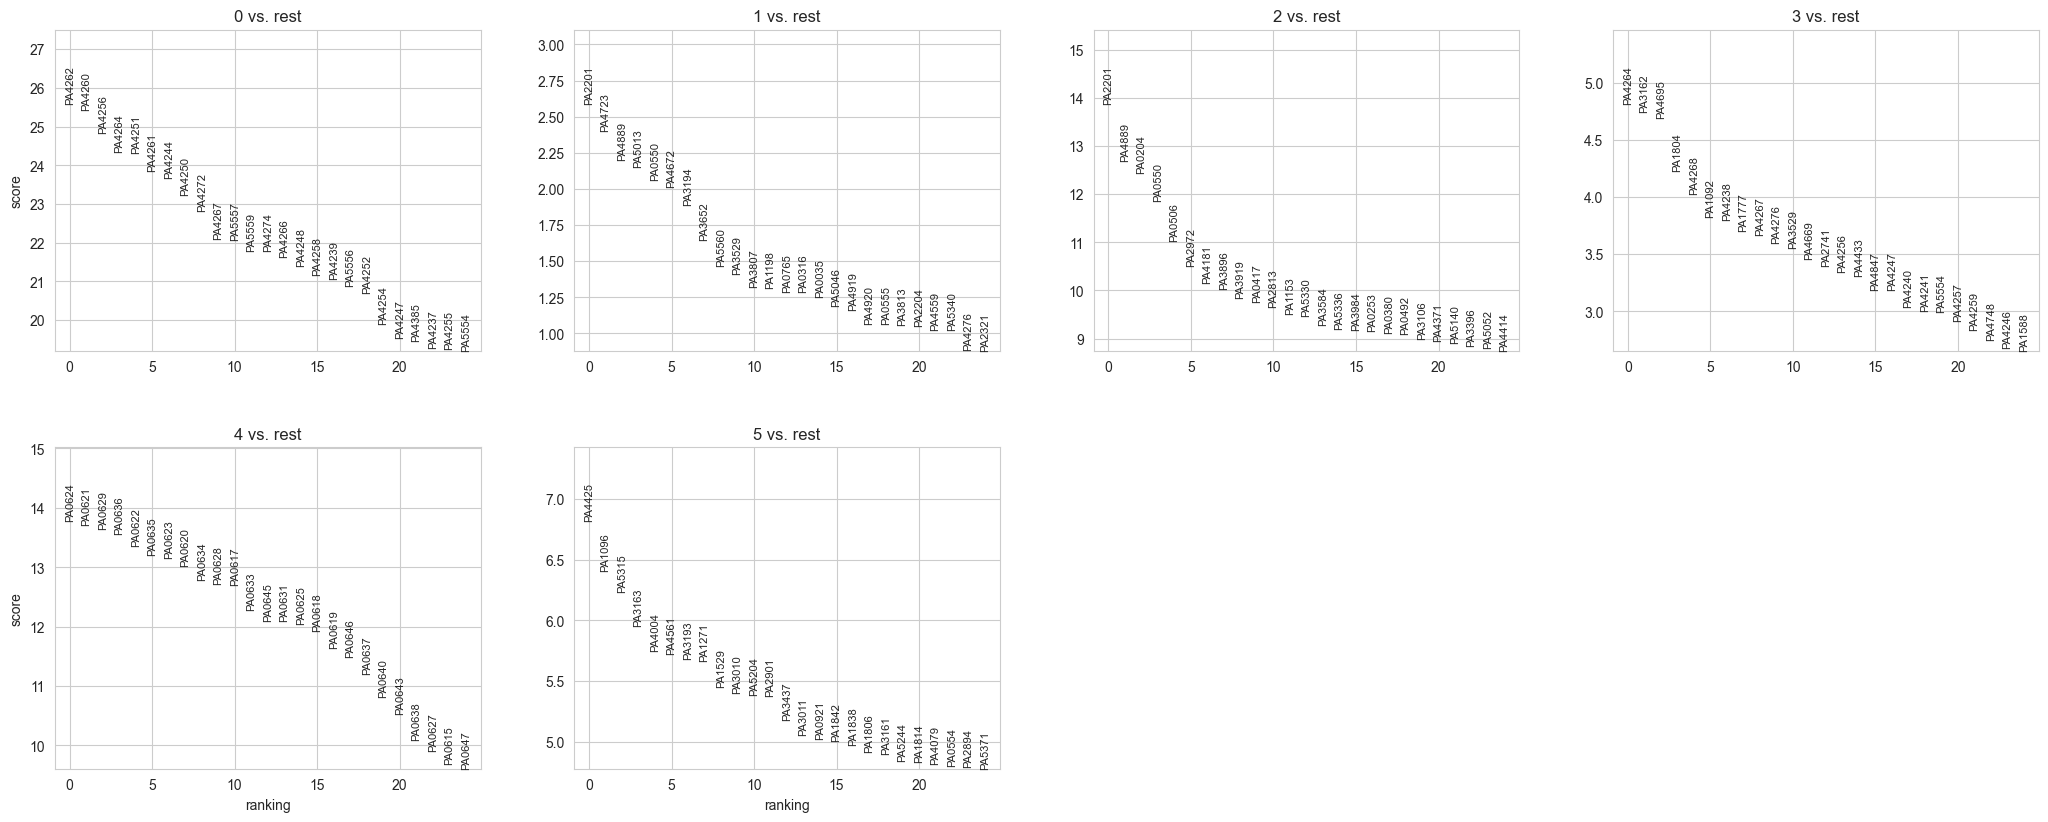

In [113]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [114]:
data_gene

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'embedding_reliability_colors', 'leiden', 'leiden_opt_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
    obsp: 'distances', 'connectivities'

In [115]:
top_genes_3 = [x[3] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA4264', 'PA3162', 'PA4695', 'PA1804', 'PA4268', 'PA1092', 'PA4238', 'PA1777', 'PA4267', 'PA4276', 'PA3529', 'PA4669', 'PA2741', 'PA4256', 'PA4433', 'PA4847', 'PA4247', 'PA4240', 'PA4241', 'PA5554', 'PA4257', 'PA4259', 'PA4748', 'PA4246', 'PA1588']


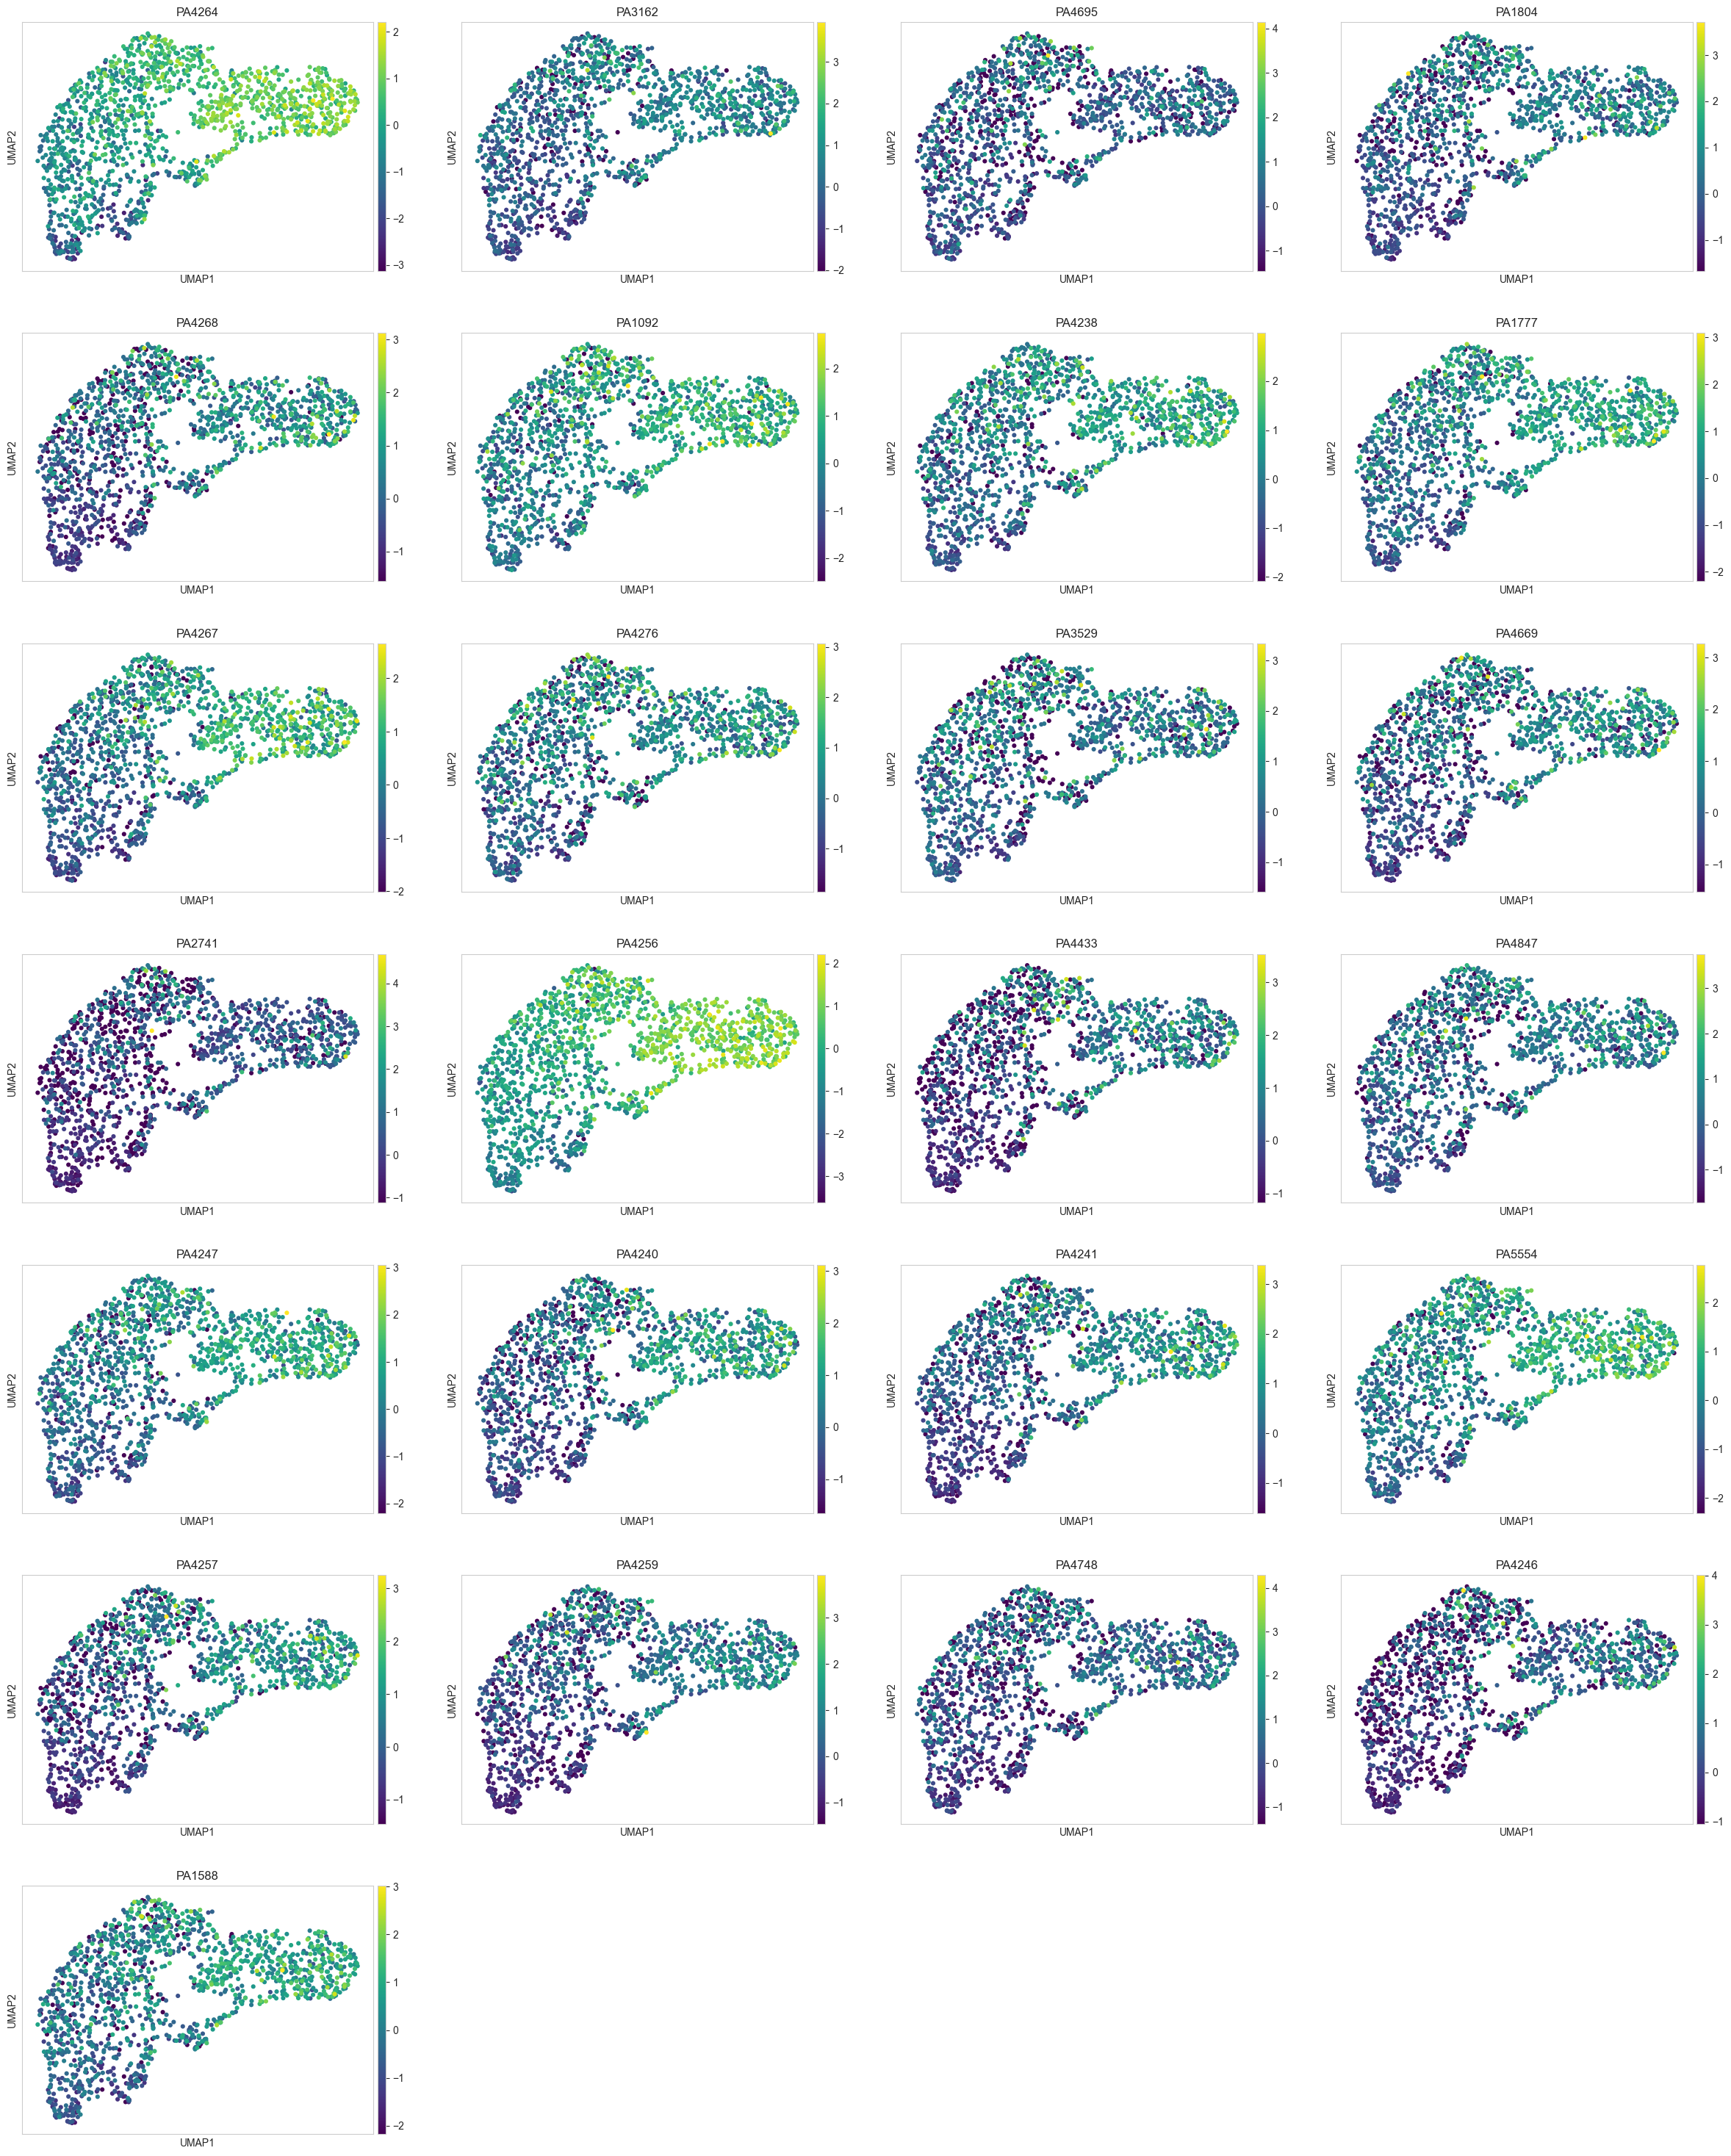

In [116]:
sc.pl.umap(data_gene, color=top_genes_3[:25], palette="tab20", cmap="viridis")

In [117]:
top_genes_4 = [x[4] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_4[:25])

['PA0624', 'PA0621', 'PA0629', 'PA0636', 'PA0622', 'PA0635', 'PA0623', 'PA0620', 'PA0634', 'PA0628', 'PA0617', 'PA0633', 'PA0645', 'PA0631', 'PA0625', 'PA0618', 'PA0619', 'PA0646', 'PA0637', 'PA0640', 'PA0643', 'PA0638', 'PA0627', 'PA0615', 'PA0647']


In [118]:
top_genes_5 = [x[5] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_5[:25])

['PA4425', 'PA1096', 'PA5315', 'PA3163', 'PA4004', 'PA4561', 'PA3193', 'PA1271', 'PA1529', 'PA3010', 'PA5204', 'PA2901', 'PA3437', 'PA3011', 'PA0921', 'PA1842', 'PA1838', 'PA1806', 'PA3161', 'PA5244', 'PA1814', 'PA4079', 'PA0554', 'PA2894', 'PA5371']


In [119]:
top_genes_2 = [x[2] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_2[:25])

['PA2201', 'PA4889', 'PA0204', 'PA0550', 'PA0506', 'PA2972', 'PA4181', 'PA3896', 'PA3919', 'PA0417', 'PA2813', 'PA1153', 'PA5330', 'PA3584', 'PA5336', 'PA3984', 'PA0253', 'PA0380', 'PA0492', 'PA3106', 'PA4371', 'PA5140', 'PA3396', 'PA5052', 'PA4414']
